## Startup

In [1]:
import os
import data_import
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math

max_iterations = 100000

plt.rcParams.update({'font.size': 20})
plt.rc('figure', figsize=(20, 10))


SEEDS = [i for i in range(1,100)]


In [2]:
cache = {}


def exec(N, h, t, s, v=0.01, tm=1):
    dir = "output/{}_{}_{}_{}_{}_{}".format(n, h, t, s, v, tm)
    os.makedirs(dir, exist_ok=True)
    os.chdir(dir)
    key = (N, h, t, s, v, tm)
    c = cache.get(key)
    if not c:

        command = f"java -cp ../../target/gasDiffusion-1.0-SNAPSHOT.jar -DnumParticles={N} -DholeSize={h} -Dseed={s} -Dthreshold={t} -DmaxIterations={max_iterations} -DinitialVelocity={v} -DtimeMultiplier={tm} gasDiffusion.Main"
        proc = os.popen(command)
        time = proc.readlines()[-1]
    else:
        time = c
    data = data_import.Data("2DGasDiffusion.txt")
    cache[key] = time
    os.chdir("../../")
    return (time, data)


## 1.2

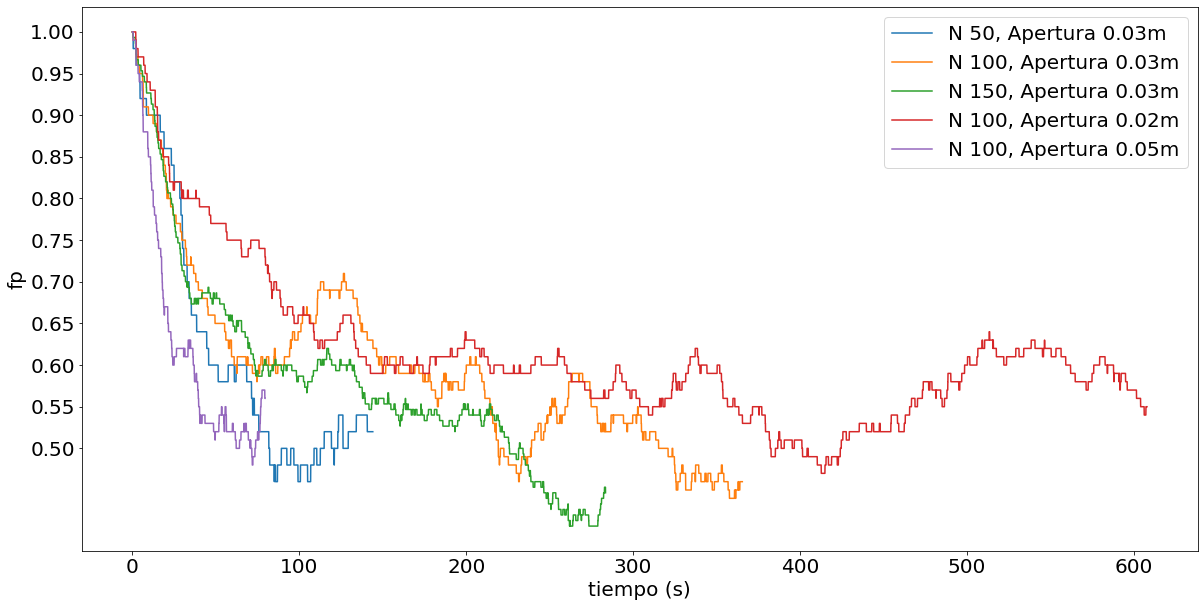

In [3]:
C = [
    (50, 0.03), (100, 0.03), (150, 0.03), (100, 0.02), (100, 0.05)
]

plt.figure("fp vs tiempo")
plt.xlabel("tiempo (s)")
plt.ylabel("fp")


for c in C:
    n, h = c
    count = []
    times = []
    time, data = exec(n, h, 0.05, 2022, v=0.01, tm = 2)

    for time, a, b, m, t, _data in data:
        count.append(a)
        times.append(time)

    plt.plot(times, count, label=f"N {n}, Apertura {h}m")

plt.legend()
plt.yticks(np.arange(0.5, 1.05, 0.05))
plt.show()



## 1.2.2.a

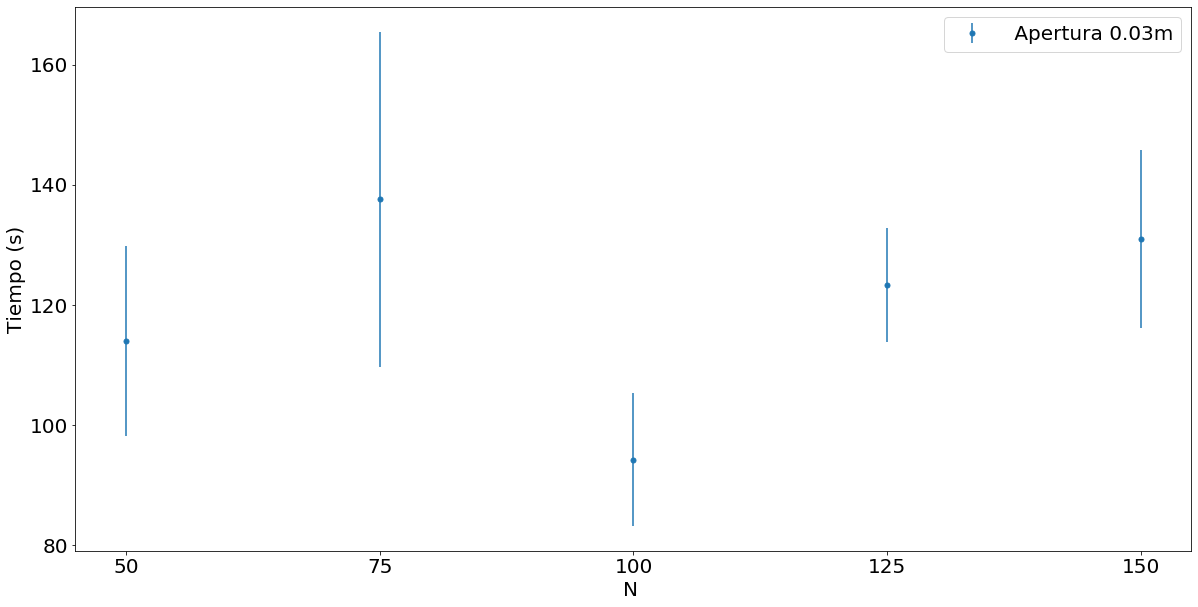

In [4]:
seeds = SEEDS[0:5]
N = [50, 75, 100, 125, 150]
h = 0.03

avg = []
errors = []

plt.figure("Tiempo vs N")
plt.xlabel("N ")
plt.ylabel("Tiempo (s)")

for n in N:
    times = []
    for s in seeds:
        time, data = exec(n, h, 0.05, s)
        times.append(time)
    avg.append(statistics.mean(map(float, times)))
    errors.append(statistics.stdev(map(float, times))/math.sqrt(len(times)))

plt.errorbar(N, avg, yerr=errors, fmt="o",
             label=f" Apertura {h}m", markersize=5)
plt.legend()
plt.xticks(N)
plt.show()



## 1.2.2.b

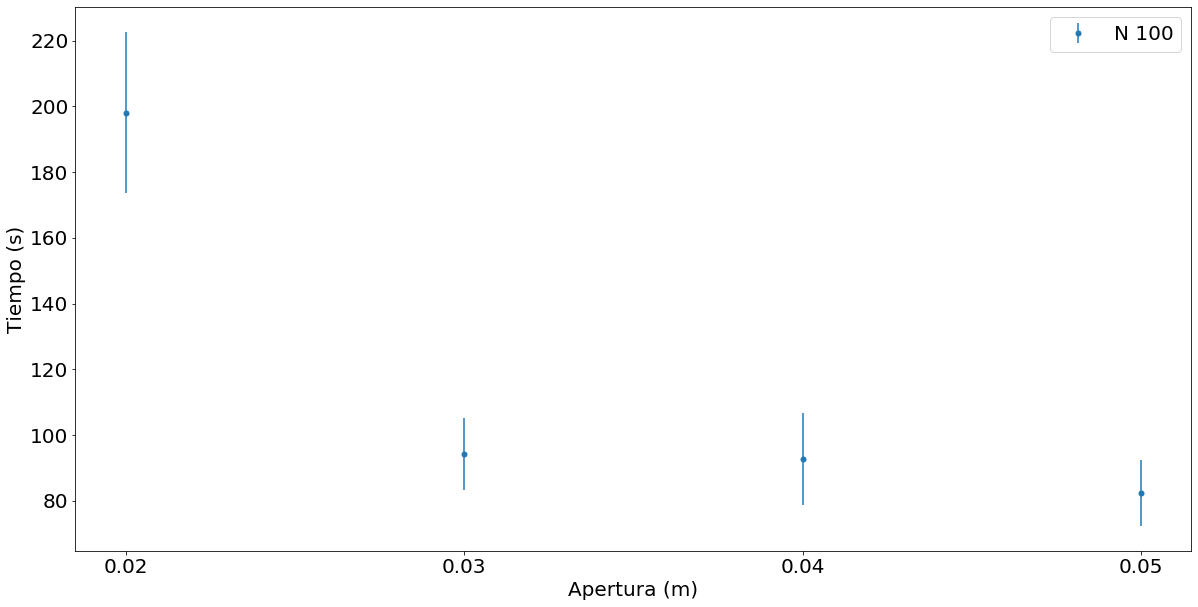

In [8]:
seeds = SEEDS[0:5]
H = [0.02, 0.03, 0.04, 0.05]
n = 100

avg = []
errors = []

plt.figure("Tiempo vs  Apertura")
plt.xlabel("Apertura (m)")
plt.ylabel("Tiempo (s)")

for h in H:
    times = []
    for s in seeds:
        time, data = exec(n, h, 0.05, s)
        times.append(time)
    avg.append(statistics.mean(map(float, times)))
    errors.append(statistics.stdev(map(float, times))/math.sqrt(len(times)))

plt.errorbar(H, avg, yerr=errors, fmt="o",
             label=f"N {n}", markersize=5)
plt.legend()
plt.xticks(H)
plt.show()


## 1.3.1

0.0002721994652812144
0.005534555726885076
0.004355191444499431


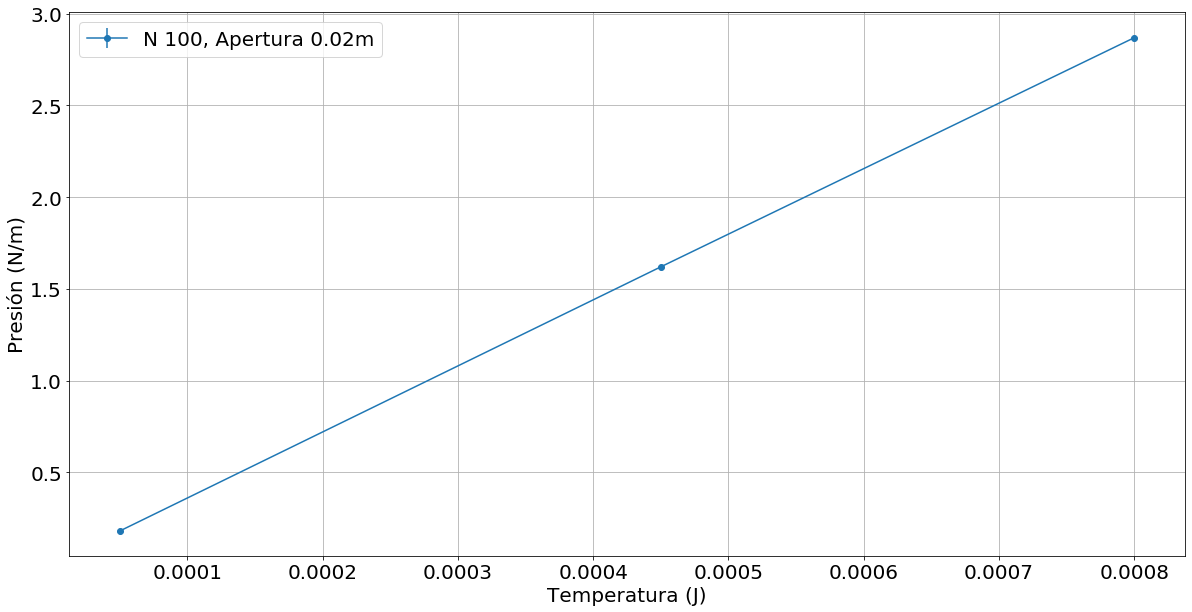

In [6]:
n = 100
h = 0.02
tm = 2
length = 0.24*2 + 0.9*2

V = [0.01, 0.03, 0.04]

seeds = SEEDS[0:5]

pressures = []
temperatures = []
temperature_errors = []
pressure_errors = []


for v in V:

    press = []
    
    temperatures.append(0.5*1*v**2)
    

    for s in seeds:
        time, data = exec(n, h, 0.05, s, v, tm)
        time = float(time)
        
        end_time = time
        start_time = time/tm

        initial_momentum = 0
        end_momentum = 0

        time = 0
        try:
            while(True):
                if time < start_time:
                    inital_momentum = data.momentum_ag
                else:
                    end_momentum = data.momentum_ag
                time = data.event_t
                data.update_data()
                data.update_header()
                
        except:
            pass       
        

        press.append((end_momentum-initial_momentum) /
                     (length * (end_time - start_time)))


    pressure = statistics.mean(press)
    press_err = statistics.stdev(press)/math.sqrt(len(press))
    pressures.append(pressure)
    pressure_errors.append(press_err)
    
plt.figure("P vs T")
plt.xlabel("Temperatura (J)")
plt.ylabel("Presión (N/m)")
plt.errorbar(temperatures, pressures,yerr=pressure_errors, fmt="o-", label=f"N {n}, Apertura {h}m")
plt.grid()
plt.legend()
plt.show(0.01)
    

## 1.4

(3586.76 0.00003)


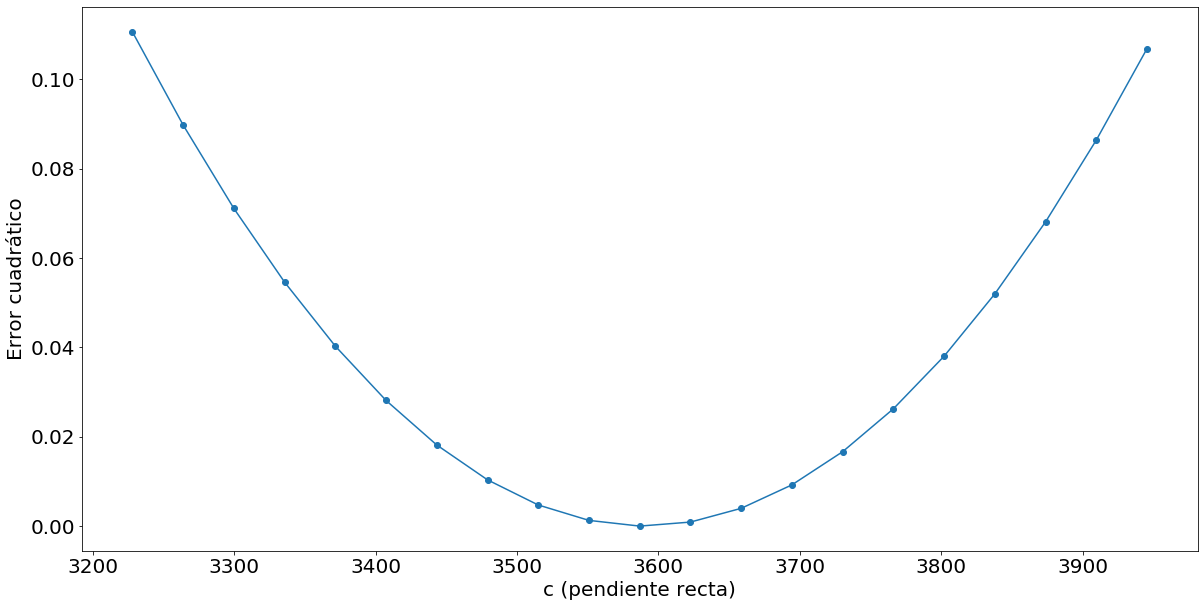

In [15]:
c = (pressures[-1] - pressures[0])/(temperatures[-1] - temperatures[0])
co = c - c*0.1
cf = c + c*0.1

C = np.arange(co, cf, c*0.01)


def error(c):
    return sum([(p - t*c)**2 for p, t in zip(pressures, temperatures)])


plt.figure("Error vs C")
plt.ylabel("Error cuadrático")
plt.xlabel("c (pendiente recta)")

errors = [error(c) for c in C]

plt.plot(C, errors, "o-")

c, error = min(zip(C, errors), key=lambda x: x[1])



print("({:.2f} {:.5f})".format(c,error))



plt.show()
